### Clasificador en inglés

Categorías del dataset _all_sample_:

- 0: negativo
- 1: positivo
- 2: neutral
- 3: irrelevante

Categorías utilizadas para la clasificación:

- 0: tuits irrelevantes y neutrales
- 1: tuits positivos y negativos

#### Exportamos librerías

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd, os, numpy as np
from collections import Counter
from time import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import hstack, csr_matrix

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, average_precision_score, make_scorer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#### Exportamos el dataset

In [2]:
df_sample = pd.read_csv('data/all_sample.csv')
df_sample.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], inplace=True)

In [3]:
# sent = SentimentIntensityAnalyzer()

# df_sample['negative'] = df_sample['preprocessed_text'].apply(lambda x: sent.polarity_scores(x)['neg'])
# df_sample['neutral'] = df_sample['preprocessed_text'].apply(lambda x: sent.polarity_scores(x)['neu'])
# df_sample['positive'] = df_sample['preprocessed_text'].apply(lambda x: sent.polarity_scores(x)['pos'])
# df_sample['compound'] = df_sample['preprocessed_text'].apply(lambda x: sent.polarity_scores(x)['compound'])

# df_sample['length'] = [len(x) if type(x) == str else 0 for x in df_sample.preprocessed_text]
df_sample['relevance'] = [0 if x == 3 or x == 2 else 1 for x in df_sample.labels]

#### Dividimos en train y test

In [4]:
data_train, data_test, y_train, y_test = \
    train_test_split(df_sample, df_sample['relevance'], test_size=0.3, random_state=5)

In [5]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=1000, min_df=2, max_df=0.5) # 
term_freq_matrix = count_vectorizer.fit_transform(data_train['preprocessed_text'].values.astype('U'))

tfidf = TfidfTransformer(norm="l2")
tfidf.fit(term_freq_matrix)
tf_idf_matrix = tfidf.transform(term_freq_matrix)

tfidf_vectorizer = TfidfVectorizer(min_df = 1)
X_train = tfidf_vectorizer.fit_transform(data_train['preprocessed_text'].values.astype('U'))
X_test  = tfidf_vectorizer.transform(data_test['preprocessed_text'].values.astype('U'))

In [6]:
extra_features_train = data_train[['polarity','subjectivity', 'punctuation']].to_numpy()
extra_features_val = data_test[['polarity','subjectivity', 'punctuation']].to_numpy()

scaler = MaxAbsScaler().fit(extra_features_train)
extra_features_train = csr_matrix(scaler.transform(extra_features_train))
extra_features_val = csr_matrix(scaler.transform(extra_features_val))
    
X_train = hstack((X_train, extra_features_train))
X_test = hstack((X_test, extra_features_val))

#### SMOTE para equilibrar el dataset

In [7]:
counter = Counter(y_train)
print('Before oversampling: ', counter)

# transform the dataset
oversample = SMOTE(sampling_strategy='all', random_state=42, k_neighbors=1)
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After oversampling: ', counter)

Before oversampling:  Counter({1: 918, 0: 482})
After oversampling:  Counter({0: 918, 1: 918})


### Probamos distintos clasificadores

Optamos por SVM porque es el que da mejores resultados

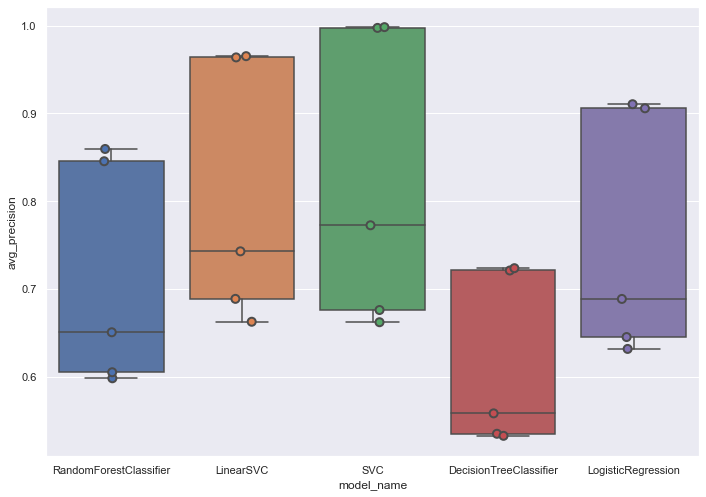

In [8]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(C=1, random_state=42),
    SVC(C=1, kernel='rbf', gamma='scale'),
    DecisionTreeClassifier(),
    LogisticRegression(random_state=0),
]

CV = 5
df_cv = pd.DataFrame(index = range(CV * len(models)))
result = []

for model in models:
    
    model_name = model.__class__.__name__
    
    scores = cross_val_score(model, X_train, y_train, scoring='average_precision', cv=CV)
    
    for fold_idx, score in enumerate(scores):
        result.append((model_name, fold_idx, score))
    df_cv = pd.DataFrame(result, columns=['model_name', 'fold_idx', 'avg_precision'])


sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x='model_name', y='avg_precision', data=df_cv)
sns.stripplot(x='model_name', y='avg_precision', data=df_cv, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [9]:
df_cv.groupby('model_name').avg_precision.mean()

model_name
DecisionTreeClassifier    0.613911
LinearSVC                 0.804628
LogisticRegression        0.756293
RandomForestClassifier    0.711676
SVC                       0.821268
Name: avg_precision, dtype: float64

### Parámetros

GridSearchCV para encontrar los mejores parámetros

In [10]:
def grid_search(clf, X_train, y_train, tuned_parameters, scorers, refit_score='precision'):
    
    skf = KFold(n_splits=10, shuffle=True, random_state=1)

    grid_search = GridSearchCV(clf, tuned_parameters, scoring=scorers, refit=refit_score,
                               cv=skf, n_jobs=1, return_train_score=True)
    grid_search.fit(X_train, y_train)
    print('------Analysis orientated to {}------:'.format(refit_score))
    print('Best parameters ({}): {}'.format(refit_score, grid_search.best_params_))
    print('Best score ({}): {}'.format(refit_score, grid_search.best_score_))
    return grid_search

In [11]:
t = time()

precision_scorer = make_scorer(precision_score, zero_division=0)

custom_scoring = {"precision": precision_scorer}

# score_orien = 'precision'

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 1, 10, 100],
                     'C': [0.1, 1, 5, 10, 15, 50, 100, 250, 500, 1000]},
                    {'kernel': ['linear'], 'C': [0.1, 1, 5, 10, 15, 50, 100, 250, 500]}]

grid_svm = grid_search(SVC(), X_train, y_train, tuned_parameters, custom_scoring)

print('----------Clasification----------')
print('Train score ({}): {}'.format(custom_scoring, grid_svm.score(X_train, y_train)))
print('Test score ({}): {}'.format(custom_scoring, grid_svm.score(X_test, y_test)))

results = pd.DataFrame(grid_svm.cv_results_)

print('Time: {} mins'.format(round((time() - t) / 60, 2)))

------Analysis orientated to precision------:
Best parameters (precision): {'C': 500, 'kernel': 'linear'}
Best score (precision): 0.8296021249430161
----------Clasification----------
Train score ({'precision': make_scorer(precision_score, zero_division=0)}): 0.9978046103183315
Test score ({'precision': make_scorer(precision_score, zero_division=0)}): 0.7139364303178484
Time: 38.8 mins


In [14]:
results.filter(items=['params', 'mean_test_precision', 'std_test_precision',
                        'mean_train_precision', 'std_train_precision']).sort_values('mean_test_precision', ascending=False)

,params,mean_test_precision,std_test_precision,mean_train_precision,std_train_precision
98,"{'C': 500, 'kernel': 'linear'}",0.829602,0.036703,0.997326,0.001046
84,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",0.829214,0.036349,0.997083,0.001228
94,"{'C': 15, 'kernel': 'linear'}",0.827464,0.035404,0.997083,0.001228
93,"{'C': 10, 'kernel': 'linear'}",0.827175,0.037758,0.997081,0.001109
95,"{'C': 50, 'kernel': 'linear'}",0.826745,0.035542,0.997084,0.001228
...,...,...,...,...,...
45,"{'C': 50, 'gamma': 1e-05, 'kernel': 'rbf'}",0.289941,0.236924,0.301120,0.245866
63,"{'C': 250, 'gamma': 1e-05, 'kernel': 'rbf'}",0.289941,0.236924,0.301120,0.245866
46,"{'C': 50, 'gamma': 0.0001, 'kernel': 'rbf'}",0.289941,0.236924,0.301120,0.245866
1,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.289941,0.236924,0.301120,0.245866


### Test

Probamos el clasificador con los datos del test

In [15]:
def plot_confusion_matrix(y, y_pred, title, labels):
    cf_matrix = confusion_matrix(y, y_pred)
    plt.figure()
    sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='g', linewidths=.5,
                annot_kws={"size": 10}, cmap="YlGnBu")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)

In [16]:
y_pred = grid_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
print('ACCURACY: ', accuracy)
print('PRECISION: ', precision)

ACCURACY:  0.62
PRECISION:  0.5663922989285577


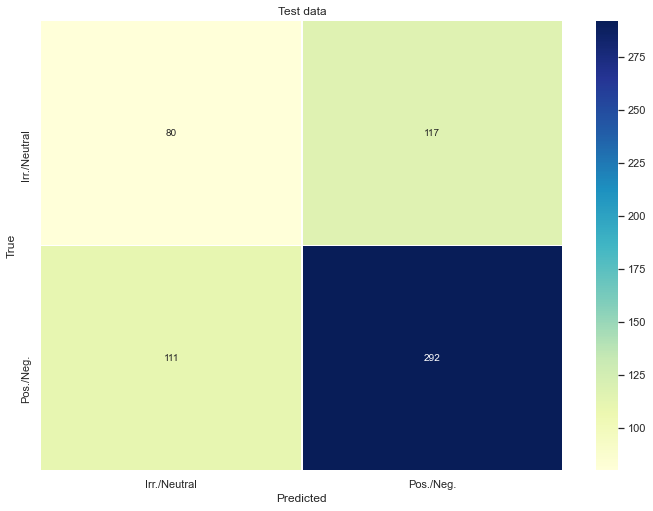

In [17]:
plot_confusion_matrix(y_test, y_pred, 'Test data', ['Irr./Neutral', 'Pos./Neg.'])

In [18]:
print(classification_report(y_test, y_pred, target_names=['Irr./Neutral', 'Pos./Neg.']))

              precision    recall  f1-score   support

Irr./Neutral       0.42      0.41      0.41       197
   Pos./Neg.       0.71      0.72      0.72       403

    accuracy                           0.62       600
   macro avg       0.57      0.57      0.57       600
weighted avg       0.62      0.62      0.62       600

